# IHP 130nm Tech Narrowband 160 GHz LNA Factory

This notebook contains the parametrized cell-like factories for the generation of a 4-stage 160GHz narrowband (27 GHz) RF LNA. 

The PCell is generated for a single stage, including parametric decoupling and matching RF MIM capacitors, parametric inductance stubs controlled through their length for biasing the decoupled nodes, parametric NPN BJT transistors and biasing resistors. For multiple stage approach, it is required to generate each stage and cascade them.

In [1]:
from pathlib import Path
import gdsfactory as gf
from gdsfactory import Component
from gdsfactory.typings import LayerSpec

In [2]:
# Add IHP module to Python path
import sys
sys.path.insert(0, '/home/martin/Desktop/IHP-gdsfactory')

In [3]:
from ihp import PDK, cells, cells2
from capacitors import rfcmim

2026-02-02 12:11:31.069 | WARNING  | doroutes.pcells:<module>:25 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-02 12:11:31.077 | WARNING  | doroutes.pcells:<module>:48 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-02 12:11:31.079 | WARNING  | doroutes.pcells:<module>:110 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-02 12:11:31.080 | WARNING  | doroutes.pcells:<module>:149 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-02 12:11:31.081 | WARNING  | doroutes.pcells:<module>:168 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to con

In [4]:
PDK.activate()

In [6]:
@gf.cell
def lna_160g_stage(
    npn_emitter_width: float = 0.07,
    npn_emitter_length: float = 0.9,
    m: int = 4,
    rows: int = 16,
    rfcmim_width: float = 14.28,
    rfcmim_length: float = 9.28,
    rfcmim_width2: float = 3.0,
    rfcmim_length2: float = 31.0,
    ymax_ref: float | None = None,
    emitter_stub_length: float = 94.66,
    output_stub_length: float = 71.0,
    bias_con_length: float = 30.0,
    layer_metal1draw: LayerSpec = "Metal1drawing",
    layer_metal2pin: LayerSpec = "Metal2pin",
    layer_metal2draw: LayerSpec = "Metal2drawing",
    layer_metal2label: LayerSpec = "Metal2label",
    layer_metal5draw: LayerSpec = "Metal5drawing",
    layer_metal5pin: LayerSpec = "Metal5pin",
    layer_topmetal1draw: LayerSpec = "TopMetal1drawing",
    layer_topmetal1pin: LayerSpec = "TopMetal1pin",
    layer_topmetal1label: LayerSpec = "TopMetal1label",
    layer_topmetal2draw: LayerSpec = "TopMetal2drawing",
    layer_topmetal2pin: LayerSpec = "TopMetal2pin",
    layer_topmetal2label: LayerSpec = "TopMetal2label",
    model = "rflna_stage",
)-> Component:
    """
    Generates the layout for a single stage of a 160 GHz Low Noise Amplifier (LNA).

    The stage includes input/output matching capacitors (RF MIM), a Bi-Polar 
    Junction Transistor (BJT) amplifier (NPN), biasing resistors (Rhigh/Rsil), 
    and associated passive routing structures (stubs, tapers, vias).

    The layout is constructed by placing, rotating, and aligning component references,
    followed by adding detailed routing, tapers, pins, and ports.

    

    Args:
        npn_emitter_width: Width of the NPN emitter finger (microns).
        npn_emitter_length: Length of the NPN emitter finger (microns).
        m: Multiplier for the NPN transistor (number of fingers/devices).
        rows: Number of rows used for the via stacks connecting to the active device.
        rfcmim_width: Width of the input MIM capacitor.
        rfcmim_length: Length of the input MIM capacitor.
        rfcmim_width2: Width of the output MIM capacitor.
        rfcmim_length2: Length of the output MIM capacitor.
        ymax_ref: Optional vertical reference coordinate (ymax) for the Rhigh resistor.
            If None, defaults to the ymax of the input RF MIM.
        emitter_stub_length: Length of the grounded emitter matching stub.
        output_stub_length: Length of the grounded output matching stub.
        bias_con_length: Length offset for the VBB bias connection rectangle.
        
        # --- Layer Arguments ---
        layer_metal1draw (LayerSpec): Layer for Metal1 drawing.
        layer_metal2pin (LayerSpec): Layer for Metal2 pin definition (e.g., VBB).
        layer_metal2draw (LayerSpec): Drawing layer for general routing on Metal 2.
        layer_metal2label (LayerSpec): Text label layer associated with Metal 2 features.
        layer_metal5draw (LayerSpec): Drawing layer for general routing and shapes on Metal 5.
        layer_metal5pin (LayerSpec): Definition of a contact/port on Metal 5.
        layer_topmetal1draw (LayerSpec): Drawing layer for the first upper metal level (e.g., RF matching).
        layer_topmetal1pin (LayerSpec): Definition of a contact/port on Top Metal 1 (e.g., RFIN/RFOUT pins).
        layer_topmetal1label (LayerSpec): Text label layer associated with Top Metal 1 features.
        layer_topmetal2draw (LayerSpec): Drawing layer for the second upper metal level (e.g., power/ground stubs).
        layer_topmetal2pin (LayerSpec): Definition of a contact/port on Top Metal 2 (e.g., VCC/GND pins).
        layer_topmetal2label (LayerSpec): Text label layer associated with Top Metal 2 features.

        model (str): The name assigned to the component's info dictionary for simulation/modeling.

    Returns:
        Component: A GDSFactory Component containing the complete LNA stage layout.

    Raises:
        ImportError: If required cells (rfcmim, npn13G2, via_stack, etc.) are not available.
    """
    c = Component()

    # ----------------------------------------------------------------
    # 1. LOCAL CONSTANTS (Replacing Magic Numbers)
    # ----------------------------------------------------------------
    
    # Spacing and Positioning
    NPN_SPACING = 0.6
    NPN_Y_OFFSET = 5.0
    RSIL_Y_OFFSET = 1.7
    VBB_PAD_SIZE = 5.0
    VBB_X_OFFSET = 5.0
    
    # Component Dimensions
    RHIGH_DY = 6.0
    RHIGH_DX = 1.9
    RSIL_DX = 7.5
    RSIL_DY = 5.0
    GND_STUB_WIDTH = 15.0
    GND_STUB_HEIGHT = 3.9
    STUB_WIDTH = 3.0
    OUT_STUB_WIDTH = 9.0
    
    # Via Configuration
    VIA2_VBB_COLS = 5
    VIA_RHIGH_P2_COLS = 4
    NPN_TERM_VIA_COLS = 3
    NPN_COL_X_OFFSET = 0.645
    
    # Routing and Taper Dimensions
    COL_RSIL_Y_OFFSET = 2.0
    OUT_STUB_STAGE_W1 = 4.0
    TAPER_LENGTH_SHORT = 3.0

    rfmim1 = c.add_ref( 
        rfcmim(width=rfcmim_width, length=rfcmim_length))
    rhigh1 = c.add_ref(
        cells.resistors.rhigh(dy = 6.0, dx = 1.9, model="rhigh"))
    rhigh1.xmin = rfmim1.xmax + 0.6
    rhigh1.ymax = rfmim1.ymax if ymax_ref is None else ymax_ref
    rfnpn1 = c.add_ref(
        cells2.npn13G2(emitter_width=npn_emitter_width, emitter_length=npn_emitter_length,Nx=m))

    rfnpn1.rotate(-90)
    rfnpn1.xmin = rfmim1.xmax + 0.6
    rfnpn1.ymax = rhigh1.ymin - 5.0
    #rfnpn1.ymin = rfmim1.ymin + 1.0

    rsil1 = c.add_ref(
        cells.resistors.rsil(dx=7.5, dy=5.0))
    rsil1.ymin = rhigh1.ymin + 1.7
    rsil1.xmin = rhigh1.xmax + 0.6
    rfcmim2 = c.add_ref(
        rfcmim(width=rfcmim_width2, length=rfcmim_length2))
    rfcmim2.xmin = rsil1.xmax + 0.6
    rfcmim2.y = rfmim1.y

    # add biasing from stage to exterior
    vbb = c.add_ref(gf.components.rectangle(
        size=(5.0, 5.0),
        layer=layer_metal2pin
    ))
    vbb.xmin = rfmim1.xmin-5.0
    vbb.ymin = rhigh1.ymax + bias_con_length
    vbb_port = c.add_port(
        name="VBB", 
        center=(vbb.x, vbb.y), 
        width=5.0, 
        orientation=-90, 
        layer=layer_metal2pin
    )
    via2acc_vbb1 = c.add_ref(cells2.via_stack(
        bottom_layer="Metal1",
        top_layer="Metal2",
        vn_columns = 5,
        vn_rows = 1))
    via2acc_vbb1.x = rhigh1.ports["P1"].center[0]
    via2acc_vbb1.ymin = rhigh1.ports["P1"].center[1]
    via_rhigh_p2 = c.add_ref(cells2.via_stack(
        bottom_layer="Metal1",
        top_layer="Metal5",
        vn_columns = 4,
        vn_rows = 1))
    via_rhigh_p2.x = rhigh1.ports["P2"].center[0]
    via_rhigh_p2.ymax = rhigh1.ports["P2"].center[1]
    via_rsil_p1 = c.add_ref(cells2.via_stack(
        bottom_layer="Metal1",
        top_layer="TopMetal2",
        vn_columns = 16,
        vn_rows = 4,
        vt1_columns = 9,
        vt1_rows = 2,
        vt2_columns = 4
    ))
    via_rsil_p1.x = rsil1.ports["P1"].center[0]
    via_rsil_p1.ymin = rsil1.ports["P1"].center[1] - 0.26
    via_rsil_p2 = c.add_ref(cells2.via_stack(
        bottom_layer="Metal1",
        top_layer="TopMetal1",
        vn_columns = 16,
        vn_rows = 4,
        vt1_columns = 9,
        vt1_rows = 2
    ))
    via_rsil_p2.x = rsil1.ports["P2"].center[0]
    via_rsil_p2.ymax = rsil1.ports["P2"].center[1] + 0.2
    route_bias_rhigh = c.add_ref(gf.components.shapes.L(
        width=5.0,
        size=(rhigh1.xmin-vbb.xmin, vbb.ymax - via2acc_vbb1.ymax - 2.0),
        layer=layer_metal2draw,
        port_type="electrical"
    ))
    route_bias_rhigh.xmin = vbb.xmin
    route_bias_rhigh.ymax = vbb.ymax

    # add grounded stub to emmiter
    via_emiter_gndstub = c.add_ref(cells2.via_stack(
        top_layer = "Metal5",
        bottom_layer = "Metal2",
        vn_columns = 3,
        vn_rows = rows,
    ))
    via_emiter_gndstub.x = rfnpn1.ports['E'].center[0]
    via_emiter_gndstub.y = rfnpn1.ports['E'].center[1]

    via_base_in = c.add_ref(cells2.via_stack(
        top_layer = "Metal5",
        bottom_layer = "Metal1",
        vn_columns = 3,
        vn_rows = rows,
    ))
    via_base_in.xmax = rfnpn1.ports['B'].center[0]
    via_base_in.y = rfnpn1.ports['B'].center[1]

    via_col_out = c.add_ref(cells2.via_stack(
        top_layer = "TopMetal1",
        bottom_layer = "Metal1",
        vn_columns = 3,
        vn_rows = rows,
        vt1_rows = int(rows/2),
        vt1_columns = 2
    ))
    via_col_out.xmin = rfnpn1.ports['C'].center[0] - 0.645
    via_col_out.y = rfnpn1.ports['C'].center[1]
    gnd_pin = c.add_ref(gf.components.rectangle(
        size=(15.0, 3.9),
        layer=layer_topmetal2pin
    ))
    gnd_pin.x = rfnpn1.ports['E'].center[0]
    gnd_pin.ymin = rfnpn1.ports['E'].center[1] - emitter_stub_length

    gnd = c.add_ref(gf.components.rectangle(
        size=(15.0, 3.9),
        layer=layer_topmetal2draw
    ))
    gnd.x = rfnpn1.ports['E'].center[0]
    gnd.ymin = rfnpn1.ports['E'].center[1] - emitter_stub_length
    # add grounded stud to output
    P = gf.Path()
    P += gf.path.euler(radius=5, angle=-90) # Circular arc.
    P += gf.path.straight(length=2.0)   # Straight section.
    P += gf.path.euler(radius=5, angle=90)  # Euler bend (aka "racetrack" curve).
    out_stub = Component()
    out_stub_ref = out_stub.add_ref(gf.path.extrude(P, layer=layer_topmetal2draw, width=9.0))
    out_stub_ref.rotate(-90)
    out_stub_ref.xmax = rfcmim2.xmax + 5.0
    out_stub_ref.ymax = rfcmim2.ports['PLUS'].center[1] - 5.0

    gnd2 = c.add_ref(gf.components.rectangle(
        size=(15.0, 3.9),
        layer=layer_topmetal2pin
    ))
    gnd2.x = out_stub_ref.xmin+4.5
    gnd2.ymin = out_stub_ref.ymin - output_stub_length

    c.add_ref(out_stub)
    # add routing tapers
    # in MIM to NPN base
    in_stub_width = 3.0
    in_stub_length = abs(rfmim1.ports["MINUS"].center[0] - rfmim1.xmax)
    in_rfmim_minus_stub = c.add_ref(gf.components.rectangle(
        size=(in_stub_length, in_stub_width),
        layer = layer_metal5draw
    ))
    in_rfmim_minus_stub.xmin = rfmim1.ports["MINUS"].center[0]
    in_rfmim_minus_stub.y = rfmim1.ports["MINUS"].center[1]
    # NPN collector to out MIM
    out_stub_width = 3.0
    out_stub_length = abs(rfcmim2.ports["PLUS"].center[0] - rfcmim2.xmin)
    out_rfmim_plus_stub = c.add_ref(gf.components.rectangle(
        size=(out_stub_length, out_stub_width),
        layer = layer_topmetal1draw
    ))
    out_rfmim_plus_stub.xmax = rfcmim2.ports["PLUS"].center[0]
    out_rfmim_plus_stub.y = rfcmim2.ports["PLUS"].center[1]
    # Add rhigh to NPN base connector
    r_base_con_length = via_base_in.xmax - via_rhigh_p2.xmin
    r_base_con_width = via_rhigh_p2.ymax - via_base_in.ymin
    r_base_stub = c.add_ref(gf.components.rectangle(
        size=(r_base_con_length, r_base_con_width),
        layer = layer_metal5draw
    ))
    r_base_stub.xmax = via_base_in.xmax
    r_base_stub.ymax = via_rhigh_p2.ymax 
    # Add rsil to NPN collector connector 
    rsil_col_length = 2*(rsil1.x - via_col_out.xmin)
    rsil_col_width = via_rsil_p2.ymin - 2.0 - via_col_out.ymin 
    rsil_col_stub = c.add_ref(gf.components.rectangle(
        size=(rsil_col_length, rsil_col_width),
        layer = layer_topmetal1draw
    ))
    rsil_col_stub.xmin = via_col_out.xmin
    rsil_col_stub.ymin = via_col_out.ymin
    # add tapers
    # Add input taper to base from RF MIM
    base_taper_width1 = in_stub_width
    base_taper_width2 = 2*min([
        via_rhigh_p2.ymax - in_rfmim_minus_stub.y,
        in_rfmim_minus_stub.y - via_base_in.ymin])
    base_taper_length = via_base_in.xmax - in_rfmim_minus_stub.xmax

    base_taper = c.add_ref(gf.components.taper(
        width1 = base_taper_width1,
        width2 = base_taper_width2,
        length = base_taper_length,
        layer = layer_metal5draw
    ))
    base_taper.xmax = via_base_in.xmax
    base_taper.y = in_rfmim_minus_stub.y 
    # Add output taper from collector to output RF MIM 
    col_taper_width2 = out_stub_width
    col_taper_width1 = 2*min([
        out_rfmim_plus_stub.y - rsil_col_stub.ymin,
        rsil_col_stub.ymax - out_rfmim_plus_stub.y])
    col_taper_length = -(rsil_col_stub.xmax - out_rfmim_plus_stub.xmin)

    col_taper = c.add_ref(gf.components.taper(
        width1 = col_taper_width1,
        width2 = col_taper_width2,
        length = col_taper_length,
        layer = layer_topmetal1draw
    ))
    col_taper.xmin = rsil_col_stub.xmax
    col_taper.y = out_rfmim_plus_stub.y 
    # Add taper from collector to RSIL 
    col_rsil_taper_width2 = via_rsil_p2.xmax - via_rsil_p1.xmin
    col_rsil_taper_width1 = rsil_col_stub.xmax - rsil_col_stub.xmin
    col_rsil_taper_length = via_rsil_p2.ymin - rsil_col_stub.ymax

    col_rsil_taper = c.add_ref(gf.components.taper(
        width1 = col_rsil_taper_width1,
        width2 = col_rsil_taper_width2,
        length = col_rsil_taper_length,
        layer = layer_topmetal1draw
    ))
    col_rsil_taper.rotate(90)
    col_rsil_taper.ymax = via_rsil_p2.ymin
    col_rsil_taper.x = rsil_col_stub.x

    # Add taper from emitter to emitter stub ground 
    via_emit_stub = c.add_ref(cells2.via_stack(
        bottom_layer = "Metal5",
        top_layer = "TopMetal2",
        vn_rows = 3,
        vn_columns = 7,
        vt1_rows = 3,
        vt1_columns = 7,
        vt2_rows = 1,
        vt2_columns = 3
    ))
    via_emit_stub.x = rfnpn1.ports["E"].center[0]
    via_emit_stub.ymax = rfnpn1.ymin

    enc_tm1 = 0.42
    enc_m5 = 0.1
    emit_taper_width2 = via_emiter_gndstub.xmax - via_emiter_gndstub.xmin
    emit_taper_width1 = via_emit_stub.xmax - via_emit_stub.xmin - 2*(enc_tm1 - enc_m5)
    emit_taper_length = via_emiter_gndstub.ymin - via_emit_stub.ymax + (enc_tm1 - enc_m5)

    emit_gnd_taper = c.add_ref(gf.components.taper(
        width1 = emit_taper_width1,
        width2 = emit_taper_width2,
        length = emit_taper_length,
        layer = layer_metal5draw
    ))
    emit_gnd_taper.rotate(90)
    emit_gnd_taper.ymax = via_emiter_gndstub.ymin
    emit_gnd_taper.x = via_emit_stub.x

    stub_gnd_taper = c.add_ref(gf.components.taper(
        width1 = emit_taper_width1,
        width2 = 15.0,
        length = 5.5,
        layer = layer_topmetal2draw
    ))
    stub_gnd_taper.rotate(-90)
    stub_gnd_taper.ymax = via_emit_stub.ymax - (enc_tm1 - enc_m5)
    stub_gnd_taper.x = via_emit_stub.x
    # Add rsil p1 taper 
    rsil_p1_taper_width2 = via_rsil_p1.xmax - via_rsil_p1.xmin
    rsil_p1_taper_width1 = 10.0
    rsil_p1_taper_length = 3.0

    rsil_p1_taper = c.add_ref(gf.components.taper(
        width1 = rsil_p1_taper_width1,
        width2 = rsil_p1_taper_width2,
        length = rsil_p1_taper_length,
        layer = layer_topmetal2draw
    ))
    rsil_p1_taper.rotate(-90)
    rsil_p1_taper.ymin = via_rsil_p1.ymin
    rsil_p1_taper.x = via_rsil_p1.x 
    # Add output ground stub input and output tapers 
    out_stub_stage_taper_width2 = 9.0
    out_stub_stage_taper_width1 = 4.0
    out_stub_stage_taper_length = 3.0

    out_stub_stage_taper = c.add_ref(gf.components.taper(
        width1 = out_stub_stage_taper_width1,
        width2 = out_stub_stage_taper_width2,
        length = out_stub_stage_taper_length,
        layer = layer_topmetal2draw
    ))
    out_stub_stage_taper.rotate(-90)
    out_stub_stage_taper.ymin = out_stub_ref.ymax
    out_stub_stage_taper.xmax = out_stub_ref.xmax
    out_stub_gnd_taper_width2 = 9.0
    out_stub_gnd_taper_width1 = 15.0
    out_stub_gnd_taper_length = 3.0

    out_stub_gnd_taper = c.add_ref(gf.components.taper(
        width1 = out_stub_gnd_taper_width1,
        width2 = out_stub_gnd_taper_width2,
        length = out_stub_gnd_taper_length,
        layer = layer_topmetal2draw
    ))
    out_stub_gnd_taper.rotate(90)
    out_stub_gnd_taper.ymax = out_stub_ref.ymin
    out_stub_gnd_taper.xmin = out_stub_ref.xmin - 3.0 
    # Add connections between tapers and pins  
    # Emitter stub interconnect
    gnd_stub_length = stub_gnd_taper.ymin - gnd.ymin
    gnd_stub_width = 15.0
    gnd_stub = c.add_ref(gf.components.rectangle(
        size=(gnd_stub_width, gnd_stub_length),
        layer=layer_topmetal2draw
    ))
    gnd_stub.ymax = stub_gnd_taper.ymin 
    gnd_stub.x = stub_gnd_taper.x 
    # Output stub interconnect to gnd 
    out_stub_gnd_length = out_stub_gnd_taper.ymin - gnd2.ymin
    out_stub_gnd_width = 15.0
    out_stub_gnd = c.add_ref(gf.components.rectangle(
        size=(out_stub_gnd_width, out_stub_gnd_length),
        layer=layer_topmetal2draw
    ))
    out_stub_gnd.ymax = out_stub_gnd_taper.ymin 
    out_stub_gnd.x = out_stub_gnd_taper.x 

    # Input stub interconnect 
    in_plus_stub_width = 3.0
    in_plus_stub_length = rfmim1.ports["PLUS"].center[0] - rfmim1.xmin
    in_rfmim_plus_stub = c.add_ref(gf.components.rectangle(
        size=(in_plus_stub_length, in_plus_stub_width),
        layer = layer_topmetal1draw
    ))
    in_rfmim_plus_stub.xmax = rfmim1.ports["PLUS"].center[0]
    in_rfmim_plus_stub.y = rfmim1.ports["PLUS"].center[1]
    # Output stub interconnect to output 
    mimout_plus_width = 3.0
    mimout_plus_length = abs(rfcmim2.ports["MINUS"].center[0] - rfcmim2.xmax)
    mimout_plus = c.add_ref(gf.components.rectangle(
        size=(mimout_plus_length, mimout_plus_width),
        layer = layer_metal5draw
    ))
    mimout_plus.xmin = rfcmim2.ports["MINUS"].center[0]
    mimout_plus.y = rfcmim2.ports["MINUS"].center[1]

    # Add output via stack to connect grounded stub 
    via_out_gnd = c.add_ref(cells2.via_stack(
        bottom_layer = "Metal5",
        top_layer = "TopMetal2",
        vn_rows = 3, 
        vn_columns = 3,
        vt1_columns = 2,
        vt1_rows = 2,
        vt2_columns = 1,
        vt2_rows = 2
    ))
    via_out_gnd.x = mimout_plus.xmax 
    via_out_gnd.y = mimout_plus.y 
    mimout_stub_con_width = 4.0
    mimout_stub_con_length = via_out_gnd.ymax - out_stub_stage_taper.ymax
    mimout_stub_con = c.add_ref(gf.components.rectangle(
        size=(mimout_stub_con_width, mimout_stub_con_length),
        layer = layer_topmetal2draw
    ))
    mimout_stub_con.x = out_stub_stage_taper.x
    mimout_stub_con.ymin = out_stub_stage_taper.ymax

    rfout_width = 3.0
    rfout_length = mimout_stub_con.xmax - via_out_gnd.xmin
    rfout_con = c.add_ref(gf.components.rectangle(
        size=(rfout_length, rfout_width),
        layer = layer_topmetal1draw
    ))
    rfout_con.xmin = via_out_gnd.xmin
    rfout_con.y = via_out_gnd.y
    # RSIL p1 interconnect to VCC 
    rsil_vcc_con_width = rsil_p1_taper_width1
    rsil_vcc_con_length = vbb.ymax - rsil_p1_taper.ymax
    rsil_vcc_con = c.add_ref(gf.components.rectangle(
        size=(rsil_vcc_con_width, rsil_vcc_con_length),
        layer = layer_topmetal2draw
    ))
    rsil_vcc_con.x = rsil_p1_taper.x
    rsil_vcc_con.ymin = rsil_p1_taper.ymax

    # Add pin rectangles ports 
    rfin_pin = c.add_ref(gf.components.rectangle(
        size=(3.0,3.0),
        layer=layer_topmetal1pin
    ))
    rfin_pin.xmin = in_rfmim_plus_stub.xmin 
    rfin_pin.y = in_rfmim_plus_stub.y 

    rfin_port = c.add_port(
        name="RFIN", 
        center=(rfin_pin.x, rfin_pin.y), 
        width=3.0, 
        orientation=0, 
        layer=layer_topmetal1draw
    )
    rfout_pin = c.add_ref(gf.components.rectangle(
        size=(3.0,3.0),
        layer=layer_topmetal1pin
    ))
    rfout_pin.xmax = rfout_con.xmax 
    rfout_pin.y = rfout_con.y 

    rfout_port = c.add_port(
        name="RFOUT", 
        center=(rfout_pin.x, rfout_pin.y), 
        width=3.0, 
        orientation=0,
        layer=layer_topmetal1draw
    )
    vcc_pin = c.add_ref(gf.components.rectangle(
        size=(10.0, 3.0),
        layer=layer_topmetal2pin
    ))
    vcc_pin.xmax = rsil_vcc_con.xmax 
    vcc_pin.ymax = rsil_vcc_con.ymax 

    vcc_port = c.add_port(
        name="VCC", 
        center=(vcc_pin.x, vcc_pin.y), 
        width=3.0, 
        orientation=-90, 
        layer=layer_topmetal2draw
    )

    
    gnd_port = c.add_port(
        name="GND", 
        center=(gnd.x, gnd.y), 
        width=3.9, 
        orientation=90, 
        layer=layer_topmetal2draw
    )
    gnd2_port = c.add_port(
        name="GND2", 
        center=(gnd2.x, gnd2.y), 
        width=3.9, 
        orientation=90, 
        layer=layer_topmetal2draw
    )
    gf.labels.add_port_labels(
        c,
        ports = [rfin_port, rfout_port],
        layer = layer_topmetal1label
    )

    gf.labels.add_port_labels(
        c,
        ports = [gnd_port, gnd2_port],
        layer = layer_topmetal2label
    )
    gf.labels.add_port_labels(
        c,
        ports = [vcc_port],
        layer = layer_topmetal2label
    )
    gf.labels.add_port_labels(
        c,
        ports = [vbb_port],
        layer = layer_metal2label
    )

    c.info['model'] = model
    return c

Generation of each stage individually and cascading them to replicate the design including in IHP April 2025 Tapeout Data

In [18]:
import os

# Get the notebook's directory and navigate to gds folder
GDS_PATH = Path(os.getcwd()).parent.parent / "gds"
GDS_PATH.mkdir(parents=True, exist_ok=True)

c = Component()

### First Stage

In [19]:
stg1 = c.add_ref(lna_160g_stage())

### Second Stage

In [20]:
stg2 = c.add_ref(
    lna_160g_stage(
        rfcmim_width=1.62, 
        rfcmim_length=4.48, 
        ymax_ref=13.75))

stg2.xmin = stg1.xmax - 8.0

### Third Stage

In [21]:
stg3 = c.add_ref(
    lna_160g_stage(
        rfcmim_width=1.62, 
        rfcmim_length=6.88, 
        m=2, 
        ymax_ref=13.75))
stg3.xmin = stg2.xmax - 8.0

### Fourth Stage

In [22]:
stg4 = c.add_ref(
    lna_160g_stage(
        rfcmim_width=1.62, 
        rfcmim_length=4.48, 
        m=2, 
        rfcmim_width2=5.48, 
        ymax_ref=13.75))
stg4.xmin = stg3.xmax - 8.0

### Output decoupling (RF) MIM Cap

In [23]:
cmim_out = c.add_ref(
    rfcmim(width=1.62, length=4.48))
cmim_out.xmin = stg4.xmax - 3.0

In [26]:
c.write(GDS_PATH / "ihp_160g_lna_factory_gen.gds")

## Visualize the Layout

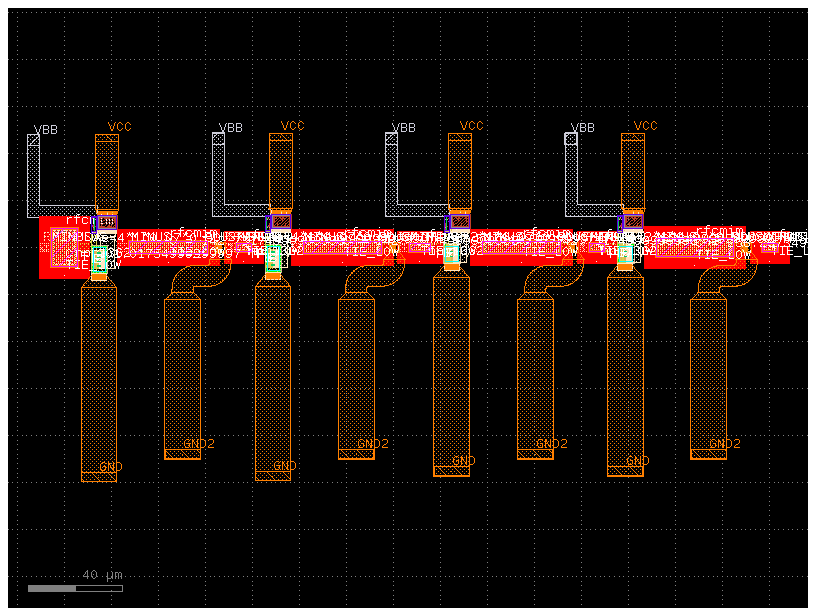

In [25]:
# Plot the complete 4-stage LNA layout
c.plot()

## Load and Plot the Saved GDS File

In [ ]:
# Import the saved GDS file back as a gdsfactory component
c_loaded = gf.import_gds(GDS_PATH / "FMD_QNC_04_160GHz_LNA.gds")

# Display information about the loaded component
print(f"Loaded component: {c_loaded.name}")
print(f"Number of polygons: {len(c_loaded.get_polygons())}")
print(f"Bounding box: {c_loaded.bbox}")

SyntaxError: invalid syntax (1043008323.py, line 2)

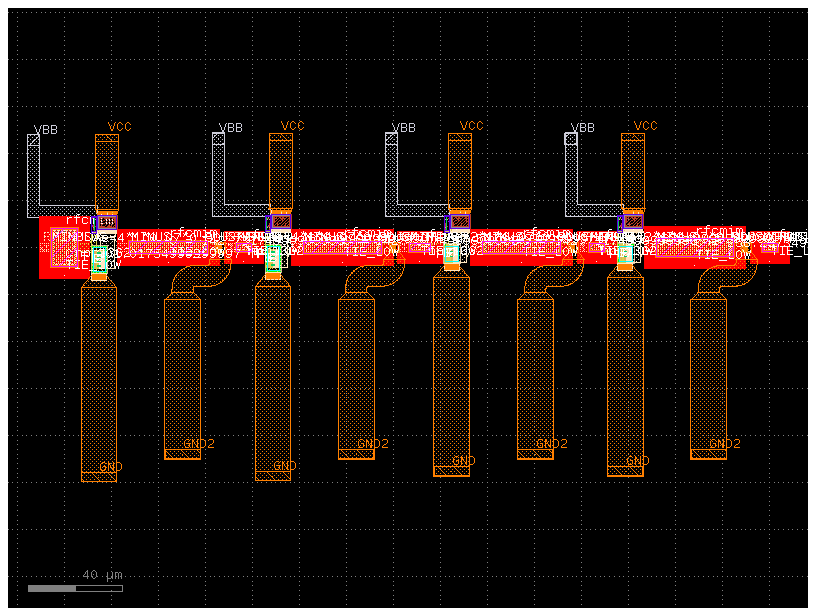

In [40]:
# Plot the loaded GDS component
c_loaded.plot()